# Линейный классификатор Softmax 

Для выполнения этого задания нужно будет дописать код в этом ноутбуке и внешнем файле classifiers/softmax.py 

Как и в упражнении с классификатором SVM, вам предстоит:

- реализовать векторизованную функцию потерь (**loss**) для Softmax классификатора
- реализовать векторизованную функцию для вычисления **аналитического градиента**
- **проверить свою реализацию** с градиентом, вычисленным методом конечных разностей
- **найти лучшие learning rate и regularization** с помощью валидационной выборки
- **оптимизировать** функцию потерь с помощью градиентного спуска **SGD**
- **визуализировать** матрицу оптимальных весов.


In [1]:
# Запустите эту ячейку если вы работаете из Google Colab
# На локальной машине запускать не нужно
!git clone https://github.com/balezz/tad_ml_dl_2021.git
!cd tad_ml_dl_2021/Assignment2
import os
os.chdir('tad_ml_dl_2021/Assignment2')
!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -O cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz 
os.getcwd()

Cloning into 'tad_ml_dl_2021'...
remote: Enumerating objects: 201, done.
remote: Counting objects: 100% (201/201), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 201 (delta 68), reused 118 (delta 23), pack-reused 0
Receiving objects: 100% (201/201), 448.77 KiB | 2.04 MiB/s, done.
Resolving deltas: 100% (68/68), done.
--2021-02-23 10:46:48--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  44.6MB/s    in 4.1s    

2021-02-23 10:46:52 (40.1 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-b

'/content/tad_ml_dl_2021/Assignment2'

In [2]:
import random
import numpy as np
from lib.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Загрузка датасета CIFAR-10 и нормализация данных.
    Алгоритм такой же как в упражнении с SVM, только обернут в функцию.  
    """
    cifar10_dir = 'cifar-10-batches-py'
    
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Вызов функции для получения подвыборок train, val, test, dev.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `lib/classifiers/softmax.py`.


In [4]:
# Реализуйте функцию вычисления softmax loss в файле classifiers/softmax.py
# с помощью циклов
from lib.classifiers.softmax import softmax_loss_naive
import time

# Инициализируем веса значениями близкими, но не равными нулю
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Проверим правильность реализации
# Для 10 классов loss должен быть около -log(0.1).
print('loss: %f' % loss)
print('Начальное значение Loss = %f' % (-np.log(0.1)))

loss: 2.304801
Начальное значение Loss = 2.302585


**Вопрос 1**

Объясните, почему мы предположили, что для 10 классов при весах близких к нулю
 softmax loss приблизительно равен -log(0.1)?  
$\color{blue}{\textit Ответ:}$ *заполнить здесь* 



In [5]:
# Дополните функцию softmax_loss_naive вычислением градиента dW
# с помощью вложенных циклов.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Как и в упражнении с SVM, используем метод конечных разностей для проверки.
from lib.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# Тест должен быть пройден и при ненулевой регуляризации
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.961348 analytic: 1.961348, relative error: 1.552254e-08
numerical: 3.179075 analytic: 3.179075, relative error: 6.084582e-09
numerical: -0.813560 analytic: -0.813560, relative error: 1.618782e-08
numerical: 2.136326 analytic: 2.136326, relative error: 1.387450e-08
numerical: -3.073843 analytic: -3.073843, relative error: 3.359552e-08
numerical: 0.022816 analytic: 0.022816, relative error: 9.904514e-07
numerical: 1.407395 analytic: 1.407395, relative error: 3.048451e-08
numerical: 1.471907 analytic: 1.471907, relative error: 1.042523e-08
numerical: -2.253937 analytic: -2.253937, relative error: 2.963557e-09
numerical: 2.049059 analytic: 2.049058, relative error: 1.220464e-08
numerical: -0.027380 analytic: -0.027380, relative error: 2.500715e-07
numerical: 0.005608 analytic: 0.005608, relative error: 2.578730e-07
numerical: 0.247284 analytic: 0.247284, relative error: 6.943000e-08
numerical: 1.544150 analytic: 1.544150, relative error: 4.133109e-08
numerical: 1.200709 analyt

In [7]:
# Теперь реализуем более эффективную векторизованную версию функции вычисления loss и dW
# Оценим, насколько быстрее стали вычисления
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from lib.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# Для оценки близости двух матриц градиентов используем норму Фробениуса
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.304801e+00 computed in 0.127751s
vectorized loss: 2.304801e+00 computed in 0.009762s
Loss difference: 0.000000
Gradient difference: 0.000000


In [17]:
# Используйте валидационную выборку для выбора лучших гиперпараметров 
# (learning rate and regularization strength)
# Добейтесь точности не меньше 0.35 на выборке val.
# Используйте словарь results в котором 
# ключи - кортеж  (learning_rate, regularization_strength)
# значения - (training_accuracy, validation_accuracy)
# Точность вычисляется как отношение числа верно предсказанных классов 
# к объему выборки
from lib.classifiers.linear_classifier import Softmax
results = {}
best_val = -1
best_softmax = None

####################################################################################
# TODO:                                                                            #
# Напишите код, позволяющий найти лучшее значение гиперпараметров на валидационной #
# выборке. Для каждой комбинации гиперпараметров обучите классификатор Softmax     #
# на train выборке, вычислите точность на выборках train, val и сохраните          #
# результат в словарь results. Лучшее значение точности сохраните в best_val       #
# лучший классификатор - в best_softmax                                            #
#                                                                                  #
# Подсказка: чтобы уменьшить время обучения, используйте dev подвыборку.           #
# После того, как код будет реализован и отлажен, замените dev на train.           #
####################################################################################



# Пример допустимых значений. Можете изменить на свое усмотрение.
learning_rates = [-6.6, -6.15]
regularization_strengths = [4.05, 4.7]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for i in range(128):
    learning_rate = np.power(10, np.random.uniform(learning_rates[0], learning_rates[1]))
    reg = np.power(10, np.random.uniform(regularization_strengths[0], regularization_strengths[1]))
    softmax = Softmax()
    
    loss_hist = softmax.train(X_train, y_train, learning_rate=learning_rate,
                          reg=reg, num_iters=300, batch_size=200, verbose=False)
    
    y_train_pred = softmax.predict(X_train)
    train_accuracy = np.mean(y_train_pred == y_train)
    y_val_pred   = softmax.predict(X_val)
    val_accuracy   = np.mean(y_val_pred == y_val)
    print(f"For iter {i} accuracy: {val_accuracy}")

    if best_val < val_accuracy:
        best_softmax, best_val = softmax, val_accuracy
        
    results[(learning_rate, reg)] = (train_accuracy, val_accuracy)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Вывод результатов.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

For iter 0 accuracy: 0.322
For iter 1 accuracy: 0.286
For iter 2 accuracy: 0.338
For iter 3 accuracy: 0.349
For iter 4 accuracy: 0.349
For iter 5 accuracy: 0.364
For iter 6 accuracy: 0.362
For iter 7 accuracy: 0.355
For iter 8 accuracy: 0.347
For iter 9 accuracy: 0.351
For iter 10 accuracy: 0.311
For iter 11 accuracy: 0.311
For iter 12 accuracy: 0.357
For iter 13 accuracy: 0.352
For iter 14 accuracy: 0.35
For iter 15 accuracy: 0.347
For iter 16 accuracy: 0.357
For iter 17 accuracy: 0.353
For iter 18 accuracy: 0.307
For iter 19 accuracy: 0.347
For iter 20 accuracy: 0.37
For iter 21 accuracy: 0.343
For iter 22 accuracy: 0.347
For iter 23 accuracy: 0.291
For iter 24 accuracy: 0.336
For iter 25 accuracy: 0.364
For iter 26 accuracy: 0.345
For iter 27 accuracy: 0.298
For iter 28 accuracy: 0.362
For iter 29 accuracy: 0.365
For iter 30 accuracy: 0.368
For iter 31 accuracy: 0.354
For iter 32 accuracy: 0.351
For iter 33 accuracy: 0.367
For iter 34 accuracy: 0.335
For iter 35 accuracy: 0.322
For 

In [18]:
# Точность на test выборке
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.371000


**Вопрос 2** - *Да или Нет*

Суммарное значение функции потерь (loss) на всей train выборке равно сумме потерь для каждого отсчета. Существует такой отсчет (изображение), который можно добавить в train выборку, при этом значение loss для SVM классификатора не изменится. Для Softmax классификатора такого отсчета не существует.    
  
$\color{blue}{\textit Ответ:}$


$\color{blue}{\textit Объясните:}$



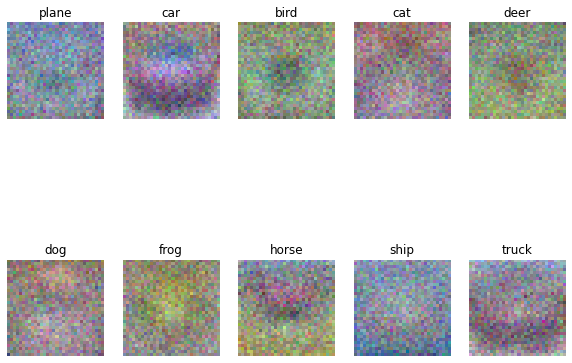

In [19]:
# Визуализируем веса W для каждого класса
w = best_softmax.W[:-1,:] # отбросим фиктивное измерение bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Масштабируем веса в значения от 0 до 255 для визуализации
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

# ПОЗДРАВЛЯЕМ!

Это конец задания. Не забудьте сохранить этот ноутбук и файл softmax.py